<a href="https://colab.research.google.com/github/aleksmirosh/Big-Data-School/blob/main/Geo_Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalations

In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# install findspark 
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.0.0


In [5]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import geopy.distance

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.model_selection import StratifiedKFold

import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Reading row data

As this is a big data and raw files the first step is to read each file and save it as a dataframe.

There are 188 folders (users) with one label file and a lot of trajectories files for each.

In [6]:
#create schema for label files, geo trajectory files and their combine version

label_schema = StructType([
    StructField("Start_Time", StringType(), True),        
    StructField("End_Time", StringType(), True),
    StructField("Mode", StringType(), True)])

geo_schema = StructType([
    StructField("Latitude", DoubleType(), True),        
    StructField("Longitude", DoubleType(), True),
    StructField("Zero", DoubleType(), True),
    StructField("Altitude", DoubleType(), True),
    StructField("DateMod", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Time", StringType(), True)])

full_schema = StructType([
    StructField("Latitude", DoubleType(), True),        
    StructField("Longitude", DoubleType(), True),
    StructField("Altitude", DoubleType(), True),
    StructField("Time", TimestampType(), True),
    StructField("Start_Time", TimestampType(), True),
    StructField("End_Time", TimestampType(), True),
    StructField("Mode", StringType(), True),
    StructField("Id", IntegerType(), True)])

In [ ]:
#read files with labels

def create_label_set(dir_name):
  # CSV options
  file_location = "/content/drive/MyDrive/Colab Notebooks/Geolife Trajectories 1.3/Data/{}/labels.txt".format(dir_name)
  file_type = "csv"
  infer_schema = "false"
  first_row_is_header = "true"
  delimiter = "\t"

  label_df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .schema(label_schema)\
          .option("sep", delimiter) \
          .load(file_location)

  # add new column with user id and converting times to timestamp
  label_df = label_df.withColumn('Id', lit(dir_name))\
            .withColumn('Start_Time', to_timestamp(label_df['Start_Time'], 'yyyy/MM/dd HH:mm:ss'))\
            .withColumn('End_Time', to_timestamp(label_df['End_Time'], 'yyyy/MM/dd HH:mm:ss'))

  return label_df

In [ ]:
#read files with trajectories 

def create_geo_set(dir_name):  
  file_location = "/content/drive/MyDrive/Colab Notebooks/Geolife Trajectories 1.3/Data/{}/Trajectory/*".format(dir_name)
  file_type = "csv"
  infer_schema = "false"
  first_row_is_header = "false"
  delimiter = ","

  geo_df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .schema(geo_schema)\
          .option("sep", delimiter) \
          .load(file_location)

  # drop unnecesary columns, NA rows and converting Time to timestamp format
  drop_list = ['Zero', 'DateMod', 'Date']
  geo_df = geo_df.na.drop()\
          .withColumn('Time', to_timestamp(concat(geo_df.Date, lit(' '), geo_df.Time), 'yyyy-MM-dd HH:mm:ss'))\
          .drop(*drop_list)

  return geo_df

In [ ]:
#combine labels dataframes with trajectories dataframes

def concat_df(df1, df2):
  #conditiin to concate dataframes depend on Time
  cond = [df1.Time >= df2.Start_Time, df1.Time <= df2.End_Time]
  concated_df = df1.join(df2, cond, 'inner')

  return concated_df

I can not save all data to one dataframe at once as my and colab RAM are not enogh. That's why I save each file separatly.

In [ ]:
#getting path with all data 
dir_list = os.listdir(path="/content/drive/MyDrive/Colab Notebooks/Geolife Trajectories 1.3/Data")
for i in dir_list:
  temp_dir = os.listdir(path="/content/drive/MyDrive/Colab Notebooks/Geolife Trajectories 1.3/Data/{}".format(i))

  if 'labels.txt' in temp_dir:
    # concate data from geo and labels dataframes
    df = concat_df(create_geo_set(i), create_label_set(i))
    # saving concated data to drive as separete files: one folder(user) - one csv
    df.coalesce(1).write.csv('/content/drive/MyDrive/Colab Notebooks/csv', 'append') 

Next I read each new csv file and save to one dataframe.

In [ ]:
#prepering spark df for saving full df
spark_full = SparkSession.builder.appName("full_sp").getOrCreate()
full_df = spark_full.createDataFrame([], full_schema)

file_location = "/content/drive/MyDrive/Colab Notebooks/csv/*" #read all files in folder
file_type = "csv"
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

full_df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .schema(full_schema)\
          .option("sep", delimiter) \
          .load(file_location)

In [ ]:
#save output to drive
full_df.coalesce(1).write.csv('/content/drive/MyDrive/Colab Notebooks/full/csv')

### Reading data

In [7]:
# reading final full df from drive
file_location = "/content/drive/MyDrive/Colab Notebooks/full/csv/part-00000-52138051-473a-453d-bd1f-e7c8b6663054-c000.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

full_df = full_df = spark.read.format(file_type) \
          .option("inferSchema", infer_schema) \
          .option("header", first_row_is_header) \
          .schema(full_schema)\
          .option("sep", delimiter) \
          .load(file_location)

In [ ]:
# number of rows in df
full_df.count()

5509013

In [8]:
#first looking at the data
full_df.sort('Time', 'Id', "Mode").show()

+----------------+----------------+----------------+-------------------+-------------------+-------------------+----+---+
|        Latitude|       Longitude|        Altitude|               Time|         Start_Time|           End_Time|Mode| Id|
+----------------+----------------+----------------+-------------------+-------------------+-------------------+----+---+
|39.9764666666667|116.330066666667|173.884514435696|2007-04-12 10:21:16|2007-04-12 10:21:16|2007-04-12 14:56:56|bike|163|
|         39.9764|       116.33015|173.884514435696|2007-04-12 10:21:22|2007-04-12 10:21:16|2007-04-12 14:56:56|bike|163|
|39.9759833333333|116.330466666667|114.829396325459|2007-04-12 10:21:27|2007-04-12 10:21:16|2007-04-12 14:56:56|bike|161|
|        39.97625|116.330266666667|173.884514435696|2007-04-12 10:21:43|2007-04-12 10:21:16|2007-04-12 14:56:56|bike|163|
|         39.9761|        116.3305|118.110236220472|2007-04-12 10:21:53|2007-04-12 10:21:16|2007-04-12 14:56:56|bike|161|
|39.9762333333333|116.33

### Data analysis

Adding new features: Distance and Velocity

To get the distance I have to have two points - start and finish. Also to calculate distance I can not use the formula for euclidean geometry and I have to use Haversine or Vincenty formula. I use the first one because all data collected near the equator. 

In [9]:
# adding additional columns for each row with finish latitude and longitude points, time.
windowSpec  = Window.partitionBy("Start_Time").orderBy('Id', 'Mode', 'Time')
full_df = full_df.withColumn("next_Latitude",lead("Latitude",1).over(windowSpec))\
                  .withColumn("next_Longitude",lead("Longitude",1).over(windowSpec))\
                  .withColumn("next_Altitude",lead("Altitude",1).over(windowSpec))\
                  .withColumn("next_Time",lead("Time",1).over(windowSpec))\
                  .withColumn('ID_MODE_TIME', concat_ws(' ', full_df.Id, full_df.Mode, full_df.Start_Time)) #unique identifer for each trajectory

In [10]:
# Haversinus
# calculate the distance between two points with haversine formula and converting it to meters
def distance_haver(lat1, long1, lat2, long2):
  R = 6371 #Earth's radius
  sin1 = sin((radians(lat1)-radians(lat2))/2)
  sin2 = sin((radians(long1)-radians(long2))/2)
  distance_col = abs(2*R*asin(sqrt(sin1*sin1+sin2*sin2*cos(lat1)*cos(lat2))))*1000 #new distance column
  return distance_col

udf_disth = udf(distance_haver, DoubleType())
disth_col = distance_haver(full_df.Latitude, full_df.Longitude, full_df.next_Latitude, full_df.next_Longitude)

#adding distance column
full_df = full_df.withColumn('Distance', disth_col)

#adding timediff column
full_df = full_df.withColumn('Time_diff', (col('next_Time').cast(LongType()) - col('Time').cast(LongType())))

#adding velocity column
full_df = full_df.withColumn('Velocity', full_df.Distance/full_df.Time_diff)

In the next data analysis airplane mode return NaN, so I decided to remove all NaNs row from dataframe as there are around 8 such rows.

In [11]:
#remove for airplane with Nan velocity
full_df = full_df.where(~((full_df.Mode == 'airplane') & isnan(col('Distance'))))

Adding Acceleration Feature

In [12]:
# adding additional columns for each row with last speed
full_df = full_df.withColumn("next_Velocity",lead("Velocity",1).over(windowSpec))
full_df = full_df.withColumn('Acceleration', (full_df.next_Velocity - full_df.Velocity)/full_df.Time_diff)

Adding Angle feature

Angles can show turns. That's important because airplanes, subways and trains usually don't have a lot of turns instead of cars.

In [13]:
import numpy as np
# new angle feature
def angles(lat1, long1, lat2, long2):
  dy = lat2 - lat1;
  dx = cos(math.pi/180*lat1)*(long2 - long1);
  angle = atan2(dy, dx);
  return abs(degrees(angle))

#udf_angles = udf(angles, DoubleType())
angle_col = angles(full_df.Latitude, full_df.Longitude, full_df.next_Latitude, full_df.next_Longitude)
full_df = full_df.withColumn('Angle', angle_col)

In [14]:
#if angle higher than 65 degree save it as true turn
full_df = full_df.withColumn('Angle_True', when((full_df.Angle > 65) | (full_df.Angle < -65), 1).otherwise(0))

In [15]:
full_df.show()

+----------------+----------------+----------------+-------------------+-------------------+-------------------+----+---+----------------+----------------+----------------+-------------------+--------------------+------------------+---------+------------------+------------------+--------------------+------------------+----------+
|        Latitude|       Longitude|        Altitude|               Time|         Start_Time|           End_Time|Mode| Id|   next_Latitude|  next_Longitude|   next_Altitude|          next_Time|        ID_MODE_TIME|          Distance|Time_diff|          Velocity|     next_Velocity|        Acceleration|             Angle|Angle_True|
+----------------+----------------+----------------+-------------------+-------------------+-------------------+----+---+----------------+----------------+----------------+-------------------+--------------------+------------------+---------+------------------+------------------+--------------------+------------------+----------+
|   

### Visualize Statistics

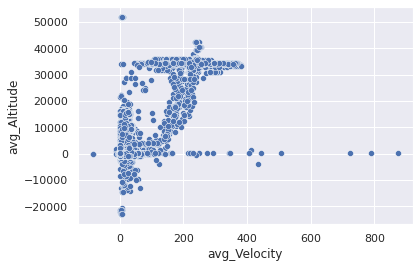

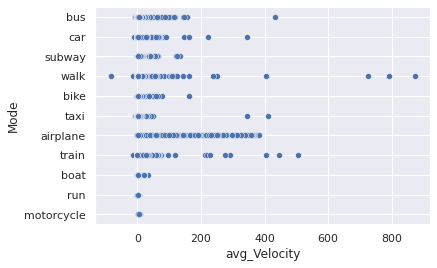

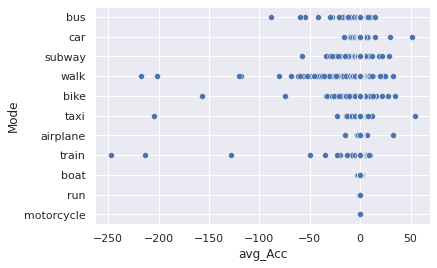

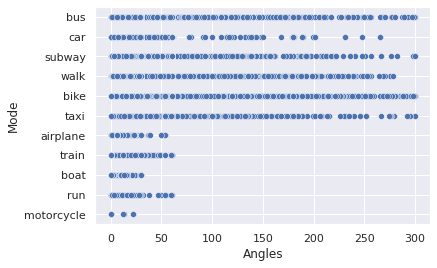

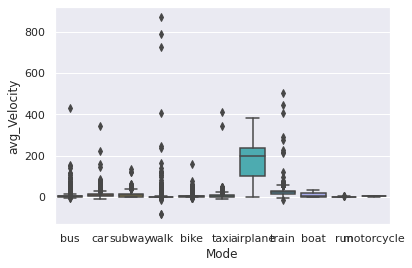

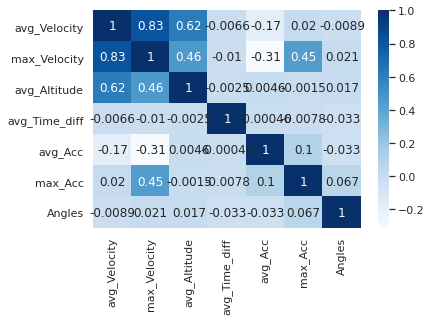

In [16]:
def visual_stat(df):
  panda = df.toPandas()  
  sns.set()
  sns.scatterplot(x=panda.avg_Velocity, y=panda.avg_Altitude)
  plt.show()
  sns.scatterplot(x=panda.avg_Velocity, y=panda.Mode)
  plt.show()
  sns.scatterplot(x=panda.avg_Acc, y=panda.Mode)
  plt.show()
  sns.scatterplot(x=panda.Angles, y=panda.Mode)
  plt.show()
  sns.boxplot(x=panda.Mode, y=panda.avg_Velocity)
  plt.show()
  sns.heatmap(panda.corr(), cbar=True, annot=True, cmap='Blues')
  plt.show()

  del panda

#define new Window Dataframe for visulalization
window_df = full_df.groupBy('ID_MODE_TIME', 'Mode', window("Time", "60 seconds"))\
        .agg(avg('Velocity').alias('avg_Velocity'), max('Velocity').alias('max_Velocity'), avg('Altitude').alias('avg_Altitude'),
             avg('Time_diff').alias('avg_Time_diff'), avg('Acceleration').alias('avg_Acc'), max('Acceleration').alias('max_Acc'), 
             sum('Angle_true').alias('Angles'))
        
visual_stat(window_df)

In [17]:
# number of each catagory
window_df.groupBy('Mode').count().show()

+----------+-----+
|      Mode|count|
+----------+-----+
|motorcycle|   12|
|       bus|54742|
|  airplane| 1095|
|     train|20257|
|      boat|  245|
|      taxi| 9067|
|      walk|71242|
|    subway|12123|
|       run|   85|
|       car|37258|
|      bike|32956|
+----------+-----+



### Conclusion. Part 1

New features were created:
 - distance
 - velocity for that distance
 - time user spent to overcome that distance
 - acceleration
 - has the distance a turn or not

Visualization shows interesting non-linear correlation between average altitude and speed. I hope this help to find airplanes. 
Also visualization show a lot of outliers. 

### Check for Outliers


There are some correlation between modes, velocity and altitude, but a lot of modes have the similar velocity and a lot of outliers. 
Motorcycles has only 12 rows, I think 12 rows are not enough for ML. Let's drop motorcycles, boats and combine vehicles

In [18]:
#combine labels
def modify_labels(data):
    if data in ['taxi', 'car', 'bus']:
        return "vehicle"
    else: 
      return data

ol_val = udf(modify_labels, StringType())

In [19]:
full_df = full_df.withColumn("Mode",ol_val(full_df.Mode)).where((full_df.Mode != 'motorcycle')&(full_df.Mode != 'boat')) 

Some data has nagetive speed, it happend because distance or time is negative, let's find 

In [20]:
#check time 
full_df.where(full_df.Time_diff < 0).count()

437

In [21]:
# remove data with negative time
full_df = full_df.where(~(full_df.Time_diff <0))

Removing outliers upon averege speed


In [22]:
#Max speed for walking is 3.3m/s, for run - 6m/s. I think I can reuse some walk data as run samples
# convert Mode walk with high speed per second to run
full_df = full_df.withColumn('Mode', when((full_df.Velocity > 5) & (full_df.Velocity < 8) & (full_df.Mode == 'walk'), 'run').otherwise(full_df.Mode))

# outliers for walk, so max speed is 3.3m/s, I took bigger dump for sporty students.
full_df = full_df.where(~((full_df.Mode == 'walk') & (full_df.Velocity > 5)))

# outliers for vehicle, max car speed in Chine - 80km/h
full_df = full_df.where(~((full_df.Mode == 'vehicle') & (full_df.Velocity > 50)))

# outliers for bus
#full_df = full_df.where(~((full_df.Mode == 'bus') & (full_df.Velocity > 80)))

# outliers for train
full_df = full_df.where(~((full_df.Mode == 'train') & (full_df.Velocity > 150)))

# outliers for subway
full_df = full_df.where(~((full_df.Mode == 'subway') & (full_df.Velocity > 120)))

# outliers for bike, avg speed - 4m/s, spormens moves much faster, but we can not split them from car in this case.
full_df = full_df.where(~((full_df.Mode == 'bike') & (full_df.Velocity > 8)))  

### Re-define new window dataframe

According to different papers, the most important features for trajectories data is average and maximum for velocity, acceleration.

In [23]:
window_df = full_df.groupBy('ID_MODE_TIME', 'Mode', window("Time", "60 seconds"))\
        .agg(avg('Velocity').alias('avg_Velocity'), max('Velocity').alias('max_Velocity'), avg('Altitude').alias('avg_Altitude'),
             avg('Time_diff').alias('avg_Time_diff'), avg('Acceleration').alias('avg_Acc'), max('Acceleration').alias('max_Acc'), 
             sum('Angle_true').alias('Angles'))

In [ ]:
window_df.show()

+--------------------+------+--------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+------+
|        ID_MODE_TIME|  Mode|              window|       avg_Velocity|       max_Velocity|      avg_Altitude|     avg_Time_diff|             avg_Acc|             max_Acc|Angles|
+--------------------+------+--------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+------+
|112 bus 2008-06-1...|   bus|[2008-06-15 01:12...|  7.723264811511603|  13.64286923280007|195.87692307692302| 2.269230769230769|-0.02555556676471389|   1.398161158443976|     0|
|69 bus 2008-06-27...|   bus|[2008-06-27 01:42...|  6.205179890641201| 12.773135288984239|226.35294117647058|1.1764705882352942|-0.03757390857929024|   3.790004116290734|    36|
|167 bus 2008-06-2...|   bus|[2008-06-29 12:45...|  3.985079021453536|  8.567623427524161|105.86666666666666|1

In [ ]:
# number of each catagory
window_df.groupBy('Mode').count().show()

+--------+------+
|    Mode| count|
+--------+------+
|airplane|  1093|
|   train| 20213|
|    boat|   243|
|    walk| 69950|
|  subway| 12006|
| vehicle|100580|
|     run|  9973|
|    bike| 32700|
+--------+------+



Modes frequency is highly different, data imbalanced.



In [ ]:
#speed statistics
window_df.groupBy('Mode').agg(max('max_Velocity'), avg('avg_Velocity'), avg('Angles')).show()

+--------+------------------+------------------+------------------+
|    Mode| max(max_Velocity)| avg(avg_Velocity)|       avg(Angles)|
+--------+------------------+------------------+------------------+
|airplane| 382.3061576044937|171.86698842543197| 6.485818847209515|
|   train|146.92123319684018|22.351892268856325| 17.96987087517934|
|    boat| 42.90407669424061|10.424218683754244| 8.679012345679013|
|    walk| 4.999948773460385|1.1035083719541885| 11.96807719799857|
|  subway| 99.39675616347367| 9.032644670925135|16.566466766616692|
| vehicle| 49.99461724923779| 7.095521082742129|12.925472260886856|
|     run|14.780457300608818| 6.107668468844587| 1.836859520705906|
|    bike|11.999386116586054| 2.995615599820059|18.441743119266054|
+--------+------------------+------------------+------------------+



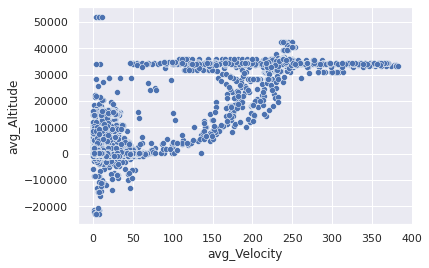

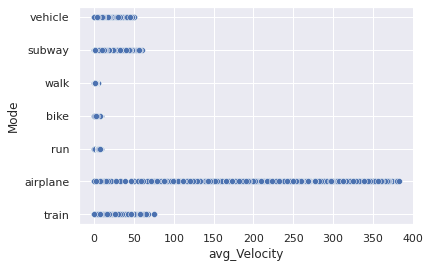

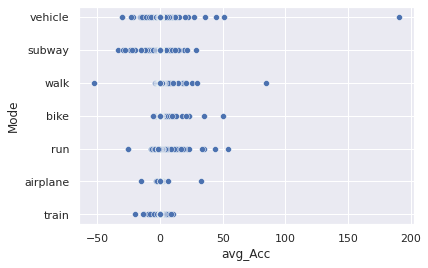

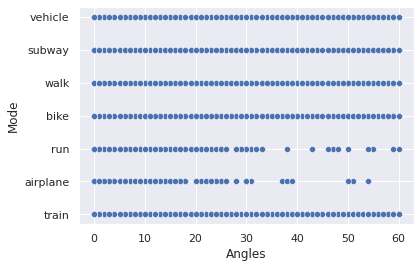

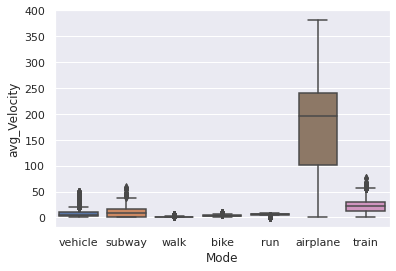

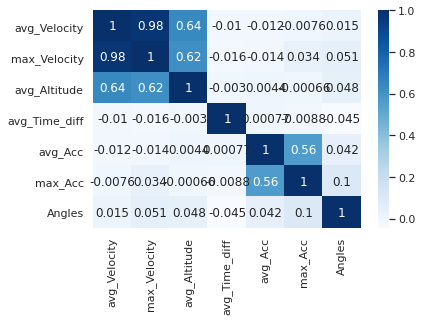

In [24]:
visual_stat(window_df)

In [ ]:
#remove Null rows for averege acceleration 
window_df = window_df.where(~(col('avg_Acc').isNull()))

### Conclusion. Part 2

I combined taxis, cars and buses to one category - vehicle. 
I removed motorcycles and boats as they don't have enough examples.

I created new dataframe using the window in 1 minute and features for it:
 - average window velocity
 - max window velocity
 - average acceleration
 - max acceleration
 - average time difference (not used)
 - average altitude
 - number of turns per minute

Outliers and nan/null values were removed as I have a lot of data and I can remove a few rows.

### Split data

In [ ]:
drop_list = ['window', 'Id', 'ID_MODE_TIME', 'avg_Time_diff'] #not used columns
dataset = window_df.drop(*drop_list)

In [ ]:
dataset.count()

246758

In [ ]:
cols = dataset.columns
feature_cols = ['avg_Velocity','max_Velocity','avg_Acc','max_Acc','Angles', 'avg_Altitude']

In [ ]:
label_stringIdx = StringIndexer(inputCol = "Mode", outputCol = "label")

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

pipeline = Pipeline(stages=[assembler, label_stringIdx])

pipelineFit = pipeline.fit(dataset)

X = pipelineFit.transform(dataset)

Data is imbalanced so I decided to split data for proportional examples in train and test datasets. For some reason, the ready function doesn't show good result and I split by hand.

In [ ]:
#split data by hand
zero = X.filter(X["label"]==0)
one = X.filter(X["label"]==1)
two = X.filter(X["label"]==2)
three = X.filter(X["label"]==3)
four = X.filter(X["label"]==4)
five = X.filter(X["label"]==5)
six = X.filter(X["label"]==6)

train0, test0 = zero.randomSplit([0.8,0.2], seed=1234)
train1, test1 = one.randomSplit([0.8,0.2], seed=1234)
train2, test2 = two.randomSplit([0.8,0.2], seed=1234)
train3, test3 = three.randomSplit([0.8,0.2], seed=1234)
train4, test4 = four.randomSplit([0.8,0.2], seed=1234)
train5, test5 = five.randomSplit([0.8,0.2], seed=1234)
train6, test6 = six.randomSplit([0.8,0.2], seed=1234)

In [ ]:
# define train and test dataset
trainingData = train0.union(train1).union(train2).union(train3).union(train4).union(train5).union(train6)
testData = test0.union(test1).union(test2).union(test3).union(test4).union(test5).union(test6)

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=20, regParam=0.003, elasticNetParam=0.5)

lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)

In [ ]:
predictions = lrModel.transform(testData)

In [ ]:
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(predictions))

0.5503368867120323


In [ ]:
import sklearn 

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.80      0.68     19907
         1.0       0.64      0.90      0.75     13765
         2.0       0.61      0.05      0.10      6424
         3.0       0.79      0.21      0.34      4141
         4.0       0.00      0.00      0.00      2436
         5.0       0.89      0.39      0.55      1911
         6.0       1.00      0.02      0.04       198

    accuracy                           0.62     48782
   macro avg       0.64      0.34      0.35     48782
weighted avg       0.61      0.62      0.55     48782



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic regression shows not high results

### Random Forest

In [ ]:
from pyspark.mllib.tree import RandomForest

In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=30, bootstrap=True, maxDepth = 10)

rfModel = rf.fit(trainingData)

predictions = rfModel.transform(testData)

In [ ]:
# check F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(predictions))

0.7567443376380779


Let's check the details to see what transport was recognized.

In [ ]:
import sklearn 

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.73      0.78     19907
         1.0       0.68      0.97      0.80     13765
         2.0       0.76      0.65      0.70      6388
         3.0       0.90      0.75      0.82      4141
         4.0       0.69      0.14      0.24      2436
         5.0       0.93      0.95      0.94      1911
         6.0       1.00      0.82      0.90       198

    accuracy                           0.77     48746
   macro avg       0.83      0.72      0.74     48746
weighted avg       0.78      0.77      0.76     48746



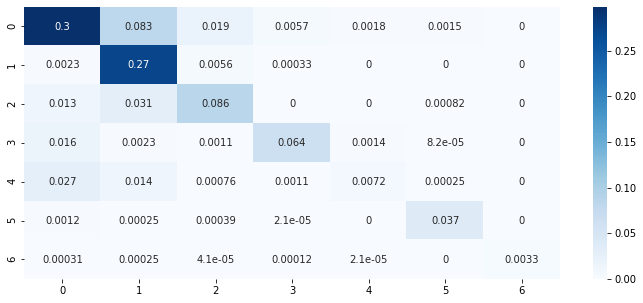

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,5))
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues')

In [ ]:
#checking modes and their labels to be sure I did all right
predictions.groupby('Mode', 'label').agg(avg('avg_Velocity')).show()

+--------+-----+------------------+
|    Mode|label| avg(avg_Velocity)|
+--------+-----+------------------+
|     run|  5.0| 6.133693349954592|
|   train|  3.0|22.269274768609364|
| vehicle|  0.0|  7.01150979197341|
|    walk|  1.0|1.0975294438514822|
|  subway|  4.0| 9.104540104861357|
|    bike|  2.0| 2.996319619704668|
|airplane|  6.0| 176.1814270242307|
+--------+-----+------------------+



The model shows a nice result.
It has some difficulty with recognizing subway but good works with other transports.
The metrics used for this Homework is accuracy and it is 77%.

In [ ]:
#some information about how RF made decisions
print(rfModel.toDebugString[:3000])

RandomForestClassificationModel: uid=RandomForestClassifier_ef8ea6e30ff3, numTrees=30, numClasses=7, numFeatures=6
  Tree 0 (weight 1.0):
    If (feature 5 <= -147.35185185185185)
     If (feature 4 <= 4.5)
      If (feature 0 <= 10.239390729538055)
       If (feature 2 <= -0.24950003742526272)
        If (feature 3 <= -0.1344722789849751)
         If (feature 1 <= 8.081018109087267)
          Predict: 5.0
         Else (feature 1 > 8.081018109087267)
          Predict: 3.0
        Else (feature 3 > -0.1344722789849751)
         If (feature 3 <= 0.5918581979639381)
          If (feature 3 <= -8.952206699744114E-4)
           If (feature 2 <= -0.7199657424101708)
            Predict: 0.0
           Else (feature 2 > -0.7199657424101708)
            Predict: 4.0
          Else (feature 3 > -8.952206699744114E-4)
           If (feature 3 <= 0.2344739875240853)
            If (feature 3 <= 0.17973903490434062)
             Predict: 0.0
            Else (feature 3 > 0.17973903490434062)
   

### Conclusion. Part 3

The model used here is Random Forest.
I did not use Gridsearch, k-fold validation here because they took too much RAM and collab stopped. So I chose parameters by hand.

The accuracy without tunning was 66% and did not work well with subway, aeroplanes and bikes, with some tunning it went to 77% and recognized airplanes and bikes well.
